In [2]:
pip install imbalanced-learn

In [3]:
!pip install ydata_profiling

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.0/390.0 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 686.1/686.1 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.8/104.8 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 25.2 MB/s eta 0:00:00
  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any.whl size=27081 sha256=848568f24a7779f437a16b41b30fc992398be44d03921cd9176d0e7b8ab0221a
  Stored in directory: /root/.cache/pip/wheels/dd/91/29/a79cecb328d01739e64017b6fb9a1ab9d8cb1853098ec5966d
Successfully built htmlmin


In [4]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.2/233.2 kB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.5 MB/s eta 0:00:00


In [5]:
from ydata_profiling import ProfileReport
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import optuna
import xgboost as xgb
from sklearn.metrics import f1_score
from sklearn.ensemble import VotingClassifier
from imblearn.over_sampling import SMOTE
from imblearn.ensemble import EasyEnsembleClassifier
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

In [9]:
# Cargar el dataset
df = pd.read_csv('stroke_dataset.csv')

# Encoding variables binarias
label_encoder = LabelEncoder()
df['ever_married'] = label_encoder.fit_transform(df['ever_married'])
df['gender'] = label_encoder.fit_transform(df['gender'])

# Crear dummies para variables categóricas
df = pd.get_dummies(df, columns=['work_type', 'Residence_type'], drop_first=True)

# Crear nuevas columnas
# 1. Grupos de edad
def age_group(age):
    if age <= 18:
        return '0-18'
    elif 19 <= age <= 35:
        return '19-35'
    elif 36 <= age <= 50:
        return '36-50'
    elif 51 <= age <= 65:
        return '51-65'
    else:
        return '65+'

df['age_group'] = df['age'].apply(age_group)

# 3. Combinación de hipertensión y enfermedades cardíacas
df['hypertension_heart_disease'] = ((df['hypertension'] == 1) & (df['heart_disease'] == 1)).astype(int)

# 4. Comorbilidades
df['comorbidities'] = df['hypertension'] + df['heart_disease']

# 5. Categorías de IMC
def bmi_category(bmi):
    if bmi < 18.5:
        return 'underweight'
    elif 18.5 <= bmi < 25:
        return 'normal'
    elif 25 <= bmi < 30:
        return 'overweight'
    else:
        return 'obese'

df['bmi_category'] = df['bmi'].apply(bmi_category)

# 6. Obesidad
df['obese'] = df['bmi'].apply(lambda x: 1 if x >= 30 else 0)

# 7. Fumador actual o pasado
df['smoker_status'] = df['smoking_status'].apply(lambda x: 1 if x in ['formerly smoked', 'smokes'] else 0)

# 8. Riesgo elevado
df['high_risk_lifestyle'] = ((df['smoker_status'] == 1) | (df['hypertension'] == 1) | (df['heart_disease'] == 1)).astype(int)

# 9. Glucosa elevada
df['high_glucose'] = df['avg_glucose_level'].apply(lambda x: 1 if x > 140 else 0)

# 10. Combinación de edad avanzada y comorbilidades
df['elderly_comorbid'] = ((df['age'] > 65) & (df['comorbidities'] > 0)).astype(int)




# Mostrar las primeras filas del DataFrame actualizado
print(df.head())


   gender   age  hypertension  heart_disease  ever_married  avg_glucose_level  \
0       1  67.0             0              1             1             228.69   
1       1  80.0             0              1             1             105.92   
2       0  49.0             0              0             1             171.23   
3       0  79.0             1              0             1             174.12   
4       1  81.0             0              0             1             186.21   

    bmi   smoking_status  stroke  work_type_Private  ...  \
0  36.6  formerly smoked       1               True  ...   
1  32.5     never smoked       1               True  ...   
2  34.4           smokes       1               True  ...   
3  24.0     never smoked       1              False  ...   
4  29.0  formerly smoked       1               True  ...   

   Residence_type_Urban  age_group  hypertension_heart_disease comorbidities  \
0                  True        65+                           0          

In [10]:
# Assuming X is your original DataFrame with features
# ... (your code to load and prepare X) ...

y = df['stroke']
X = df.drop('stroke', axis=1)

# 1. Identify categorical columns:
categorical_cols = X.select_dtypes(include=['object']).columns

# 2. Create OneHotEncoder:
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore') # sparse=False for compatibility with SMOTE

# 3. Fit and transform on categorical columns:
encoded_data = encoder.fit_transform(X[categorical_cols])

# 4. Create a new DataFrame with encoded features:
encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(categorical_cols))

# 5. Concatenate encoded features with numerical features:
X_encoded = pd.concat([X.drop(categorical_cols, axis=1), encoded_df], axis=1)

#Now use this new X_encoded for train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Calcular los pesos
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = {0: class_weights[0], 1: class_weights[1]}

# Optimización de hiperparámetros con Optuna



XGBoost

Informe de clasificación:
              precision    recall  f1-score   support

           0       0.96      0.90      0.93       947
           1       0.12      0.26      0.16        50

    accuracy                           0.87       997
   macro avg       0.54      0.58      0.55       997
weighted avg       0.92      0.87      0.89       997


Matriz de confusión:
[[852  95]
 [ 37  13]]

ROC AUC: 0.777

Importancia de las características:
age: 0.1275
gender_Male: 0.1275
Residence_type_Rural: 0.0968
Residence_type_Urban: 0.0762
work_type_Private: 0.0731
smoking_status_Unknown: 0.0631
smoking_status_never smoked: 0.0524
hypertension: 0.0503
gender_Female: 0.0493
ever_married_No: 0.0454
work_type_Govt_job: 0.0450
bmi: 0.0352
smoking_status_formerly smoked: 0.0341
smoking_status_smokes: 0.0316
avg_glucose_level: 0.0281
work_type_children: 0.0251
work_type_Self-employed: 0.0204
heart_disease: 0.0188
ever_married_Yes: 0.0000


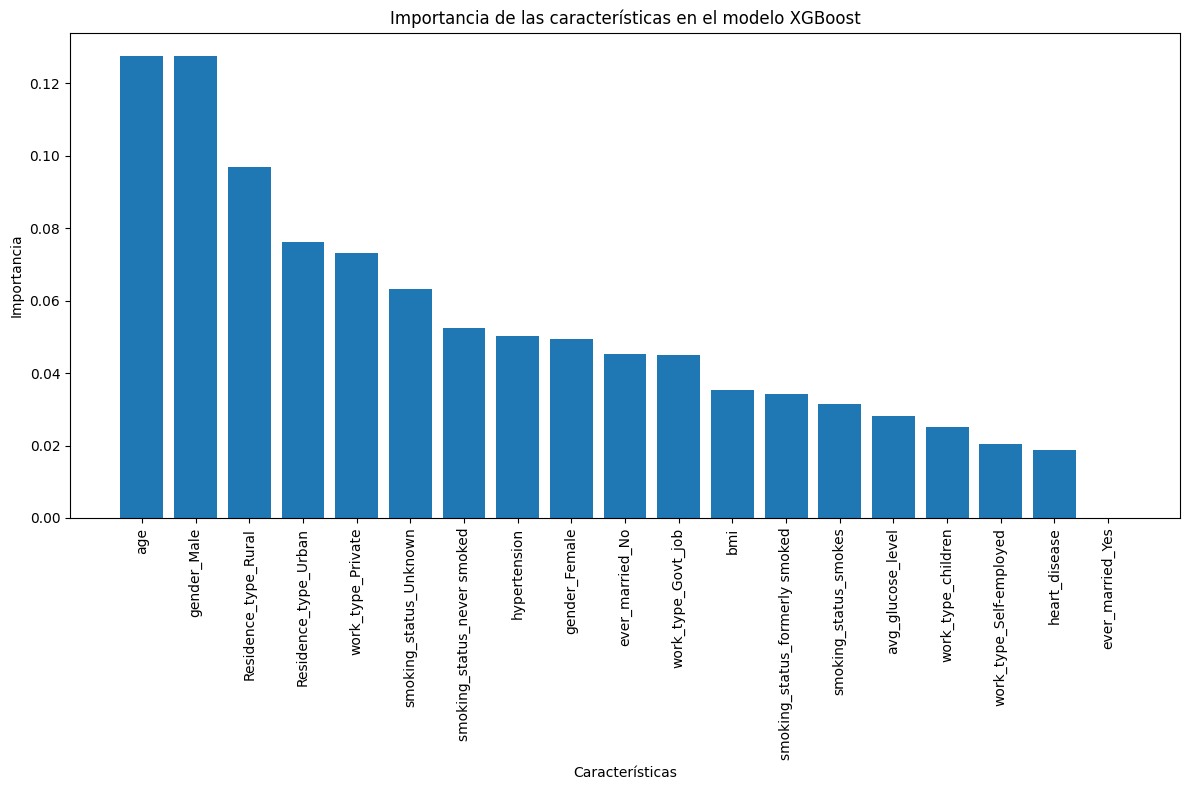

In [14]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

# Cargar los datos
df = pd.read_csv('stroke_dataset.csv')

# Preparación de los datos
df = pd.get_dummies(df, columns=['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status'])

# Selección de características
features = ['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi'] + \
           [col for col in df.columns if col.startswith(('gender_', 'ever_married_', 'work_type_', 'Residence_type_', 'smoking_status_'))]

X = df[features]
y = df['stroke']

# División de los datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Escalado de características
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Aplicar SMOTE para manejar el desbalanceo de clases
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

# Crear el modelo XGBoost con los hiperparámetros proporcionados
best_params_xgb = {
    'lambda': 0.0020347988977949456,
    'alpha': 6.065116885395498e-07,
    'colsample_bytree': 1.0,
    'subsample': 1.0,
    'learning_rate': 0.07368598010119852,
    'n_estimators': 273,
    'max_depth': 3,
    'min_child_weight': 10
}

model = XGBClassifier(**best_params_xgb, random_state=42)

# Entrenar el modelo
model.fit(X_train_resampled, y_train_resampled)

# Realizar predicciones
y_pred = model.predict(X_test_scaled)
y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

# Evaluar el modelo
print("Informe de clasificación:")
print(classification_report(y_test, y_pred))
print("\nMatriz de confusión:")
print(confusion_matrix(y_test, y_pred))
print(f"\nROC AUC: {roc_auc_score(y_test, y_pred_proba):.3f}")

# Importancia de las características
feature_importance = model.feature_importances_
feature_importance_dict = dict(zip(features, feature_importance))
sorted_features = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

print("\nImportancia de las características:")
for feature, importance in sorted_features:
    print(f"{feature}: {importance:.4f}")

# Visualización de la importancia de las características
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
plt.bar(range(len(feature_importance)), [imp for _, imp in sorted_features])
plt.xticks(range(len(feature_importance)), [feat for feat, _ in sorted_features], rotation=90)
plt.xlabel('Características')
plt.ylabel('Importancia')
plt.title('Importancia de las características en el modelo XGBoost')
plt.tight_layout()
plt.show()

Regresión lineal

#Entrenamiento del modelo

In [15]:
# Entrenar el modelo XGBoost con los mejores hiperparámetros
xgb_model_optimized = xgb.XGBClassifier(**best_params_xgb)
xgb_model_optimized.fit(X_train, y_train)

# Predecir en el conjunto de prueba
y_pred_xgb_optimized = xgb_model_optimized.predict(X_test)

# Evaluar el rendimiento del modelo optimizado
from sklearn.metrics import classification_report

In [16]:
# Extraer importancias
importances = xgb_model_optimized.feature_importances_

# Crear un DataFrame para visualizar las importancias
feature_importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
})

# Ordenar las características por importancia
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)
print("Importancia de las características:")
print(feature_importances)

Importancia de las características:
                           Feature  Importance
0                              age    0.263381
17     smoking_status_never smoked    0.087813
1                     hypertension    0.085492
10               work_type_Private    0.074240
13            Residence_type_Rural    0.073076
2                    heart_disease    0.069222
5                    gender_Female    0.051476
11         work_type_Self-employed    0.049839
7                  ever_married_No    0.048735
18           smoking_status_smokes    0.046902
3                avg_glucose_level    0.044981
9               work_type_Govt_job    0.038285
4                              bmi    0.035474
16  smoking_status_formerly smoked    0.031084
8                 ever_married_Yes    0.000000
6                      gender_Male    0.000000
12              work_type_children    0.000000
14            Residence_type_Urban    0.000000
15          smoking_status_Unknown    0.000000


In [24]:
# Seleccionar las 5 características más importantes
top_n = 6  # Cambia este valor según lo que desees
important_features = feature_importances.head(top_n)['Feature'].tolist()

# Filtrar los conjuntos de datos
X_train_important = X_train[important_features]
X_test_important = X_test[important_features]

import numpy as np
from sklearn.metrics import classification_report

# Entrenar el modelo XGBoost
xgb_model_optimized = xgb.XGBClassifier(**best_params_xgb)
xgb_model_optimized.fit(X_train_important, y_train)

# Obtener las probabilidades de las predicciones
y_prob_xgb_optimized = xgb_model_optimized.predict_proba(X_test_important)[:, 1]

# Definir un nuevo umbral
new_threshold = 0.165  # Ajusta este valor según sea necesario

# Clasificar las predicciones basadas en el nuevo umbral
y_pred_xgb_adjusted = (y_prob_xgb_optimized >= new_threshold).astype(int)

# Evaluar el rendimiento del modelo con el nuevo umbral
print("\nXGBoost Classification Report with Adjusted Threshold:")
print(classification_report(y_test, y_pred_xgb_adjusted))

from sklearn.metrics import accuracy_score

# Predecir en el conjunto de entrenamiento
y_pred_train = xgb_model_optimized.predict(X_train_important)

# Calcular la precisión en el conjunto de entrenamiento
accuracy_train = accuracy_score(y_train, y_pred_train)

# Calcular la precisión en el conjunto de prueba con el nuevo umbral
accuracy_test = accuracy_score(y_test, y_pred_xgb_adjusted)

# Calcular el porcentaje de overfitting
overfitting_percentage = (accuracy_train - accuracy_test) / accuracy_train * 100

# Imprimir los resultados
print(f"Accuracy en el conjunto de entrenamiento: {accuracy_train:.2f}")
print(f"Accuracy en el conjunto de prueba: {accuracy_test:.2f}")
print(f"Porcentaje de overfitting: {overfitting_percentage:.2f}%")


XGBoost Classification Report with Adjusted Threshold:
              precision    recall  f1-score   support

           0       0.97      0.94      0.95       947
           1       0.26      0.40      0.32        50

    accuracy                           0.91       997
   macro avg       0.62      0.67      0.64       997
weighted avg       0.93      0.91      0.92       997

Accuracy en el conjunto de entrenamiento: 0.95
Accuracy en el conjunto de prueba: 0.91
Porcentaje de overfitting: 3.85%


A PARTIR DE AQUÍ SON PRUEBAS :)

In [25]:
import pickle

# Guardar el modelo XGBoost entrenado en un archivo pickle
with open('xgb_model_optimized.pkl', 'wb') as file:
    pickle.dump(xgb_model_optimized, file)

print("Modelo XGBoost guardado exitosamente en 'xgb_model_optimized.pkl'")


Modelo XGBoost guardado exitosamente en 'xgb_model_optimized.pkl'


In [26]:
import pickle
from sklearn.metrics import classification_report, accuracy_score

# Cargar el modelo desde el archivo pickle
with open('xgb_model_optimized.pkl', 'rb') as file:
    loaded_model = pickle.load(file)

# Obtener las probabilidades de las predicciones
y_prob_xgb = loaded_model.predict_proba(X_test_important)[:, 1]

# Definir un nuevo umbral
new_threshold = 0.165  # Ajusta este valor según sea necesario

# Clasificar las predicciones basadas en el nuevo umbral
y_pred_loaded_model = (y_prob_xgb >= new_threshold).astype(int)

# Evaluar el rendimiento del modelo cargado
accuracy = accuracy_score(y_test, y_pred_loaded_model)
print(f"Accuracy del modelo cargado: {accuracy:.4f}")

# Imprimir el informe de clasificación
print("\nClassification Report del modelo cargado:")
print(classification_report(y_test, y_pred_loaded_model))


# Calcular el porcentaje de overfitting
overfitting_percentage = (accuracy_train - accuracy_test) / accuracy_train * 100
print (f"Porcentaje de overfitting: {overfitting_percentage:.2f}%")

Accuracy del modelo cargado: 0.9137

Classification Report del modelo cargado:
              precision    recall  f1-score   support

           0       0.97      0.94      0.95       947
           1       0.26      0.40      0.32        50

    accuracy                           0.91       997
   macro avg       0.62      0.67      0.64       997
weighted avg       0.93      0.91      0.92       997

Porcentaje de overfitting: 3.85%


In [21]:
!pip install tensorflow
!pip install tensorflow-gpu

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


190/190 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.6495 - loss: 0.6192 - val_accuracy: 0.7677 - val_loss: 0.6252
Epoch 2/100
190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7439 - loss: 0.4802 - val_accuracy: 0.8554 - val_loss: 0.4910
Epoch 3/100
190/190 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7869 - loss: 0.4455 - val_accuracy: 0.8561 - val_loss: 0.4664
Epoch 4/100
190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7937 - loss: 0.4357 - val_accuracy: 0.8152 - val_loss: 0.5209
Epoch 5/100
190/190 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7980 - loss: 0.4167 - val_accuracy: 0.8700 - val_loss: 0.4450
Epoch 6/100
190/190 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8073 - loss: 0.4010 - val_accuracy: 0.8634 - val_loss: 0.4452
Epoch 7/100
190/190 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8141 - loss: 0.3935 - val_accuracy: 0.8601 - val_loss: 0.4441
Epoch 8/100
190/190 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8256 - loss: 0.3805 - val_accuracy: 0.825

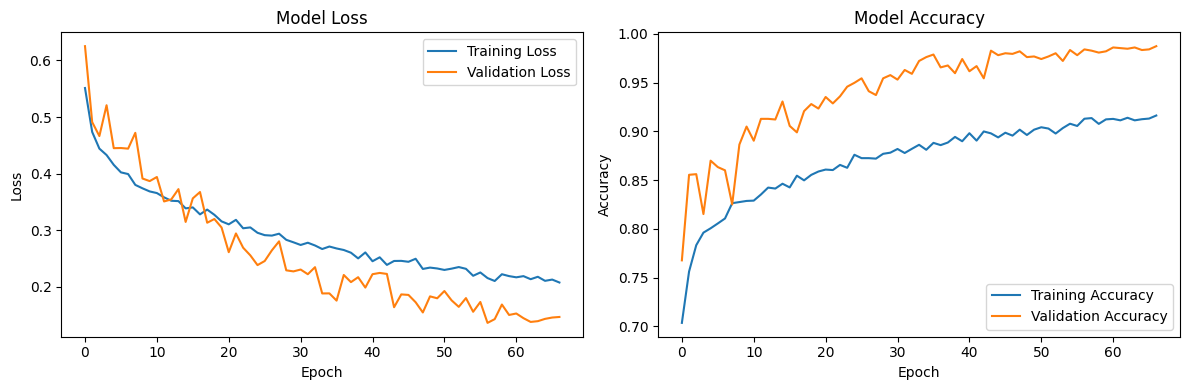

In [22]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from imblearn.over_sampling import SMOTE

# Cargar los datos
df = pd.read_csv('stroke_dataset.csv')

# Ingeniería de características (basada en tu código anterior)
df['age_glucose_risk'] = df['age'] * df['avg_glucose_level'] / 100
df['bmi_age_risk'] = df['bmi'] * df['age'] / 100
df['combined_health_risk'] = df['hypertension'] + df['heart_disease'] + (df['bmi'] > 30).astype(int) + (df['age'] > 60).astype(int) + (df['avg_glucose_level'] > 200).astype(int)

# Codificación one-hot para variables categóricas
df = pd.get_dummies(df, columns=['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status'])

# Selección de características
features = ['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi',
            'age_glucose_risk', 'bmi_age_risk', 'combined_health_risk'] + \
           [col for col in df.columns if col.startswith(('gender_', 'ever_married_', 'work_type_', 'Residence_type_', 'smoking_status_'))]

X = df[features]
y = df['stroke']

# División de los datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Escalado de características
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Aplicar SMOTE para manejar el desbalanceo de clases
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

# Crear el modelo de red neuronal
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_resampled.shape[1],)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compilar el modelo
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Definir early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Entrenar el modelo
history = model.fit(
    X_train_resampled, y_train_resampled,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

# Evaluar el modelo
y_pred_proba = model.predict(X_test_scaled)
y_pred = (y_pred_proba > 0.5).astype(int)

print("Informe de clasificación:")
print(classification_report(y_test, y_pred))
print("\nMatriz de confusión:")
print(confusion_matrix(y_test, y_pred))
print(f"\nROC AUC: {roc_auc_score(y_test, y_pred_proba):.3f}")

# Visualizar la curva de aprendizaje
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()